#1.Se importan las librerás

In [1]:
from nltk.corpus import gutenberg # obtener el corpus de la biblia
from string import punctuation # remover la puntiación 
import nltk 
import re
import numpy as np

from keras.preprocessing import text
from keras.preprocessing.sequence import skipgrams 
from keras.layers import *
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Model,Sequential

#2.Descarga del proyecto gutenberg, el modelo puntkt y las palabras vacías 

In [2]:
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('stopwords')

stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#3.Limpieza del corpus documental y tokenización

In [3]:
bible = gutenberg.sents("bible-kjv.txt")
remove_terms = punctuation + '0123456789'

In [4]:
bible

[['[', 'The', 'King', 'James', 'Bible', ']'], ['The', 'Old', 'Testament', 'of', 'the', 'King', 'James', 'Bible'], ...]

In [5]:
wpt = nltk.WordPunctTokenizer()

def normalize_document(doc):
    # Se remueven carácteres especiales y espacios 
    doc = re.sub(r'[^a-zA-Z\s]', '', doc,re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # Se tokeniza el documento
    tokens = wpt.tokenize(doc)
    # Se filtran las palabras vacías 
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # se reconstruye el docuemento tokenizado
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [7]:
norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
norm_bible = filter(None, normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

#4.Extracción de las palabras únicas y asignación de indentificadores 

In [8]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)

word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}

vocab_size = len(word2id) + 1 


wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:5])

Vocabulary Size: 12425
Vocabulary Sample: [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5)]


#5.Construcción deun skipgram 

In [9]:
# Se generna los skip-grams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10) for wid in wids]

# Se hace una muestra de los skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2word[pairs[i][0]], pairs[i][0], 
          id2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(king (13), james (1154)) -> 1
(james (1154), king (13)) -> 1
(bible (5766), wasted (2494)) -> 0
(bible (5766), king (13)) -> 1
(king (13), dismaying (11028)) -> 0
(james (1154), humiliation (11697)) -> 0
(king (13), ananiah (7614)) -> 0
(james (1154), bible (5766)) -> 1
(king (13), bible (5766)) -> 1
(bible (5766), james (1154)) -> 1


#6.Construcción de la arquitectura del modelo Skip-Gram 

In [10]:
# Construccién de la arquitectura de skip-gram 
embed_size = 100
word_model = Sequential()
word_model.add(Embedding(vocab_size, embed_size,
                         embeddings_initializer="glorot_uniform",
                         input_length=1))
word_model.add(Reshape((embed_size, )))

context_model = Sequential()
context_model.add(Embedding(vocab_size, embed_size,
                  embeddings_initializer="glorot_uniform",
                  input_length=1))
context_model.add(Reshape((embed_size,)))

merged_output = add([word_model.output, context_model.output])  

model_combined = Sequential()
model_combined.add(Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid"))

final_model = Model([word_model.input, context_model.input], model_combined(merged_output))
final_model.compile(loss="mean_squared_error", optimizer="rmsprop")

final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 embedding_1_input (InputLayer)  [(None, 1)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 100)       1242500     ['embedding_input[0][0]']        
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 100)       1242500     ['embedding_1_input[0][0]']      
                                                                                              

#7.Visualización del modelo construido 

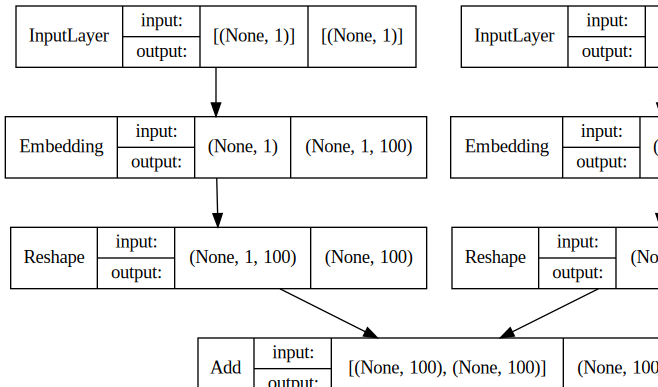

In [11]:

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(final_model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

#8.Entrenamiento del modelo 

In [12]:
for epoch in range(1, 3):
    loss = 0
    for i, elem in enumerate(skip_grams):
        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [pair_first_elem, pair_second_elem]
        Y = labels
        if i % 10000 == 0:
            print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
        loss += final_model.train_on_batch(X,Y)  

    print('Epoch:', epoch, 'Loss:', loss)

Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 1 Loss: 3625.524775485974
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 2 Loss: 3171.8099301288603


#9.Validación del modelo 

In [13]:
from sklearn.metrics.pairwise import euclidean_distances
word_embed_layer = word_model.layers[0]
weights = word_embed_layer.get_weights()[0][1:]

distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['god', 'jesus','egypt', 'john', 'famine']}

similar_words

(12424, 12424)


{'egypt': ['passover', 'sabbaths', 'male', 'multiply', 'uncleanness'],
 'famine': ['stars', 'best', 'grave', 'fruitful', 'shoulder'],
 'god': ['land', 'thy', 'thou', 'city', 'house'],
 'jesus': ['general', 'deceiveth', 'hereby', 'manifested', 'joined'],
 'john': ['bittern', 'sojourning', 'noisome', 'robber', 'serving']}